# Ring Background Estimation

## Context:
One of the challenges of IACT analysis is accounting for the large residual hadronic emission. An excess map, assumed to be a map of only gamma-ray events, requires a good estimate of the background.  However, in the absence of a solid template bkg model it is not possible to obtain reliable background model a priori. It was often found necessary in classical cherenkov astronomy to perform a local renormalization of the existing templates, usually with a ring kernel. This assumes that most of the events are background and requires to have an exclusion mask to remove regions with bright signal from the estimation. To read more about this method, see [here.](https://arxiv.org/abs/astro-ph/0610959)

## Objective:
Create an excess (gamma-ray events) map of MSH 15-52 as well as a significance map to determine how solid the signal is.

## Proposed approach:

The analysis workflow is roughly
 - Compute the sky maps keeping each observation separately using the `MapDatasetMaker`
 - Estimate the background using the `RingBackgroundMaker`
 - Compute the correlated excess and significance maps using the `CorrelatedExcessMapEstimator`
 
The normalised background thus obtained can be used for general modelling and fitting.

## Setup
As usual, we'll start with some general imports...

In [2]:
%matplotlib inline
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
from regions import CircleSkyRegion
from scipy.stats import norm

import logging

log = logging.getLogger(__name__)

Now let's import gammapy specific classes and functions

In [3]:
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    MapDataset,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, RingBackgroundMaker
from gammapy.estimators import ExcessMapEstimator
from gammapy.maps import Map
from gammapy.datasets import MapDatasetOnOff
from gammapy.maps import MapAxis, WcsGeom

## Doing the data reduction

- AIM: To create binned counts and IRFs for a few HESS runs on the pulsar wind nebula, MSH 1552


In [4]:
# source_pos = SkyCoord.from_name("MSH 15-52")
source_pos = SkyCoord(228.32, -59.08, unit="deg")

In [5]:
# define the datastore
dir = "$GAMMAPY_DATA/hess-dl3-dr1/"
datastore = DataStore.from_dir(dir)

In [6]:
# select observations: 2.5 degrees from the source position

selection = dict(
    type="sky_circle",
    frame= "icrs",
    lon= source_pos.ra,
    lat= source_pos.dec,
    radius= 2.5 * u.deg,
)

selected_obs_table = datastore.obs_table.select_observations(selection)
obsid = selected_obs_table["OBS_ID"]
observations = datastore.get_observations(obsid)

## Getting the reduced dataset
- define analysis range
- Apply safecuts
- get reduced data

In [10]:
# We now fix the energy axis for the counts map - (the reconstructed energy binning)
e_reco = MapAxis.from_energy_bounds(0.1, 10, 10, unit="TeV", name="energy")

# The WCS geometry - centered on the source
geom = WcsGeom.create(skydir=source_pos, width=3.0*u.deg, binsz=0.02, frame="galactic", axes=[e_reco])
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (150, 150, 10)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 320.3 deg, -1.1 deg
	width      : 3.0 deg x 3.0 deg



In [11]:
dataset_empty = MapDataset.create(geom=geom)

dataset_maker = MapDatasetMaker()

safe_mask_maker = SafeMaskMaker(methods=["offset-max", "aeff-default"], offset_max=2.0 * u.deg)

In [12]:
%%time
datasets = Datasets()

for observation in observations:
    dataset = dataset_maker.run(dataset_empty.copy(name=f"obs-{observation.obs_id}"), observation)
    dataset = safe_mask_maker.run(dataset, observation)
    datasets.append(dataset)

/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning

CPU times: user 12 s, sys: 990 ms, total: 13 s
Wall time: 13.1 s


## Extracting the ring background

Since the ring background is extracted from real off events, we need to use the wstat statistics in this case. For this, we will use the `MapDatasetOnOFF` and the `RingBackgroundMaker` classes.

### Create exclusion mask
First, we need to create an exclusion mask on the known sources. In this case, we need to mask only `MSH 15-52` but this depends on the sources present in our field of view.

In [16]:
# create an image geom - one bin in energy
geom_image = geom.to_image().to_cube([e_reco.squash()])

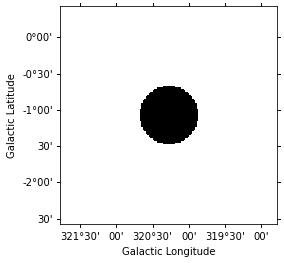

In [31]:

# Make the exclusion mask - see mask tutorial for further details
regions = CircleSkyRegion(center=source_pos, radius=0.4 * u.deg)
exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([regions], inside=False)
exclusion_mask.sum_over_axes().plot();

For the present analysis, we use a ring with an inner radius of 0.5 deg and width of 0.3 deg.

In [32]:
ring_maker = RingBackgroundMaker(
    r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
)

### Create a stacked dataset
Now, we extract the background for each dataset and then stack the maps together to create a single stacked map for further analysis

In [33]:
#%%time
energy_axis_true = datasets[0].exposure.geom.axes["energy_true"]
stacked_on_off = MapDatasetOnOff.create(
    geom=geom_image, energy_axis_true=energy_axis_true, name="stacked"
)

for dataset in datasets:
    # Ring extracting makes sense only for 2D analysis
    dataset_on_off = ring_maker.run(dataset.to_image())
    stacked_on_off.stack(dataset_on_off)

/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning

This `stacked_on_off` has `on` and `off` counts and acceptance maps which we will use in all further analysis. The `acceptance` and `acceptance_off` maps are the system acceptance of gamma-ray like events in the `on` and `off` regions respectively.

In [34]:
print(stacked_on_off)

MapDatasetOnOff
---------------

  Name                            : stacked 

  Total counts                    : 46773 
  Total background counts         : 45583.95
  Total excess counts             : 1189.05

  Predicted counts                : 45584.48
  Predicted background counts     : 45584.48
  Predicted excess counts         : nan

  Exposure min                    : 7.26e+07 m2 s
  Exposure max                    : 1.33e+10 m2 s

  Number of total bins            : 22500 
  Number of fit bins              : 22366 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 26096.33

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 96328960 
  Acceptance                      : 22500 
  Acceptance off                  : nan 



/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


## Compute correlated significance and correlated excess maps
We need to convolve our maps with an apprpriate smoothing kernel. The significance is computed according to the Li & Ma expression for ON and OFF Poisson measurements, see [here](https://ui.adsabs.harvard.edu/abs/1983ApJ...272..317L/abstract). 

We make use of the `estimators` sub-package within gammapy

In [35]:
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[])
lima_maps = estimator.run(stacked_on_off)

/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/counts_statistic.py:233: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.n_on + self.alpha ** 2 * self.n_off)
/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [36]:
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["excess"]

(<Figure size 720x720 with 4 Axes>,
 <matplotlib.colorbar.Colorbar at 0x15ac7f400>)

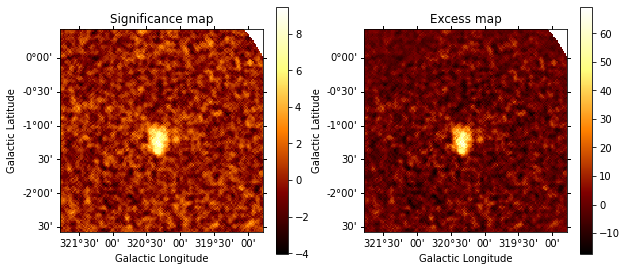

In [38]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)

(<Figure size 432x288 with 1 Axes>,
 None)

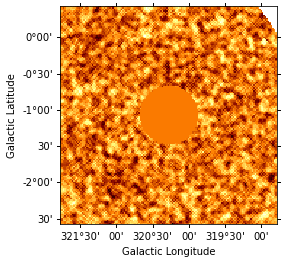

In [41]:
(significance_map * exclusion_mask).plot()

It is often important to look at the signficance distribution outside the exclusion region to check that the background estimation is not contaminated by gamma-ray events. This can be the case when exclusion regions are not large enough.
Typically, we expect the off distribution to be a standard normal distribution.

Fit results: mu = -0.01, std = 0.99


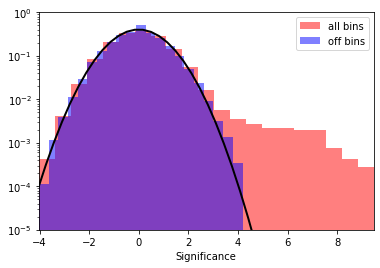

In [40]:
# create a 2D mask for the images
significance_map_off = significance_map * exclusion_mask
significance_all = significance_map.data[np.isfinite(significance_map.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")